In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5
fig_height = 4
fig_format = :png
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/run/media/alf/datos/misrepositorios/docencia/analisis-practicas-julia"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using SymPy  # Para el cálculo simbólico de integrales.
using QuadGK  # Para el cálculo numérico de integrales.
using Plots  # Para el dibujo de gráficas.
using LaTeXStrings  # Para usar código LaTeX en los gráficos.
using PrettyTables # Para formatear tablas.

In [3]:
f(x) = x^2
# Definimos la amplitud de los subintervalos.
Δx = 1/10
# Calculamos las áreas de los rectángulos tomando como altura el mínimo valor de la función en el subintervalo, que es el valor de la función en el extremo izquierdo del subintervalo.
areas_inf = [f((i-1)*Δx)*Δx for i = 1:10]
# Sumamos las áreas de los rectángulos.
sum_inf = sum(areas_inf)

0.2850000000000001

In [4]:
f(x) = x^2
# Definiendo la amplitud de los subintervalos.
Δx = 1/10
# Calculamos las áreas de los rectángulos tomando como altura el máximo valor de la función en el subintervalo, que es el valor de la función en el extremo derecho del subintervalo.
areas_sup = [f(i*Δx)*Δx for i = 1:10]
# Sumamos las áreas de los rectángulos.
sum_sup = sum(areas_sup)

0.3850000000000001

In [5]:
error = sum_sup - sum_inf

0.10000000000000003

In [6]:
using PrettyTables
f(x) = x^2

function suma_inf(f, a, b, n)
    """
    Función que calcular la suma inferior de Riemann de una función f en el intervalo [a,b] tomando una partición de n subintervalos.
    """
    Δx = (b-a)/n
    return sum([f(a+(i-1)*Δx)*Δx for i = 1:n])
end

function suma_sup(f, a, b, n)
    """
    Función que calcular la suma superior de Riemann de una función f en el intervalo [a,b] tomando una partición de n subintervalos.
    """
    Δx = (b-a)/n
    return sum([f(a+i*Δx)*Δx for i = 1:n])
end

function area(f, a, b, n)
    """
    Función que calcular de manera aproximada el área encerrada entre la gráfica de f y el eje x en el intervalo [a,b] tomando sumas de Riemann para una partición en n subintervalos, y el error cometido en la aproximación.
    """
    area_inf = suma_inf(f, a, b, n)
    area_sup = suma_sup(f, a, b, n)
    area = (area_inf + area_sup) / 2
    error = area_sup - area_inf
    return area, error
end

suma_sup(f, 0, 1, 10)  
area(f, 0, 1, 10)
areas = [area(f, 0, 1, 10^n) for n=1:6]
pretty_table(hcat(first.(areas), last.(areas)); header = ["Aproximación", "Error"])

┌──────────────┬────────┐
│ Aproximación │  Error │
├──────────────┼────────┤
│        0.335 │    0.1 │
│      0.33335 │   0.01 │
│     0.333334 │  0.001 │
│     0.333333 │ 0.0001 │
│     0.333333 │ 1.0e-5 │
│     0.333333 │ 1.0e-6 │
└──────────────┴────────┘


In [7]:
using SymPy
@syms x::real
primitiva = integrate(x^2*log(x))

 3           3
x ⋅log(x)   x 
───────── - ──
    3       9 

In [8]:
diff(primitiva)

 2       
x ⋅log(x)

In [9]:
integrate(log(log(x))/x)

log(x)⋅log(log(x)) - log(x)

In [10]:
h(x) = (2x^3+x^2+6)/(x^5-x)
# Descomposición en fracciones simples.
apart(h(x))

 5⋅x + 2         5           9       6
────────── + ───────── + ───────── - ─
  ⎛ 2    ⎞   4⋅(x + 1)   4⋅(x - 1)   x
2⋅⎝x  + 1⎠                            

In [11]:
integrate(h(x))

                                               ⎛ 2    ⎞          
            9⋅log(x - 1)   5⋅log(x + 1)   5⋅log⎝x  + 1⎠          
-6⋅log(x) + ──────────── + ──────────── + ───────────── + atan(x)
                 4              4               4                

In [12]:
@syms a::real
integrate(x^a, x)

⎧ a + 1            
⎪x                 
⎪──────  for a ≠ -1
⎨a + 1             
⎪                  
⎪log(x)  otherwise 
⎩                  

In [13]:
@syms x::real
j(x) = (1 + log(x)) * sqrt(1 + (x*log(x))^2 )
# El cálculo directo de la integral no funciona.
integrate(j(x))
# Ayudamos a SymPy con la sustitución.
h(x) = x*log(x)
@syms y::real dy::real
# Definimos la nueva función con el cambio de variable.
g(y) = j(x)(h(x) => y, diff(h(x), x) => 1)
# Integramos la nueva función y deshacemos el cambio de variable.
integrate(g(y))(y => h(x))

     ________________                         
    ╱  2    2                                 
x⋅╲╱  x ⋅log (x) + 1 ⋅log(x)   asinh(x⋅log(x))
──────────────────────────── + ───────────────
             2                        2       

In [14]:
using SymPy
@syms x::real
integrate(x^3/(x^2+x+1), (x, -1/2, 0))

         √3⋅π
-0.625 + ────
          9  

In [15]:
integrate(sqrt(16-x^2)/x, (x, 2, 4))

-2⋅√3 + 4⋅acosh(2)

In [16]:
integrate(1/(3+cos(2x)), (x, 0, PI/2))

√2⋅π
────
 8  

In [17]:
using SymPy
@syms x::real
f(x) = x^x
integrate(f(x), (x, 0, 1))

1      
⌠      
⎮  x   
⎮ x  dx
⌡      
0      

In [18]:
using QuadGK
quadgk(f(x), 0, 1, rtol = 10^-10)

(0.783430510710741, 7.598588099878845e-11)

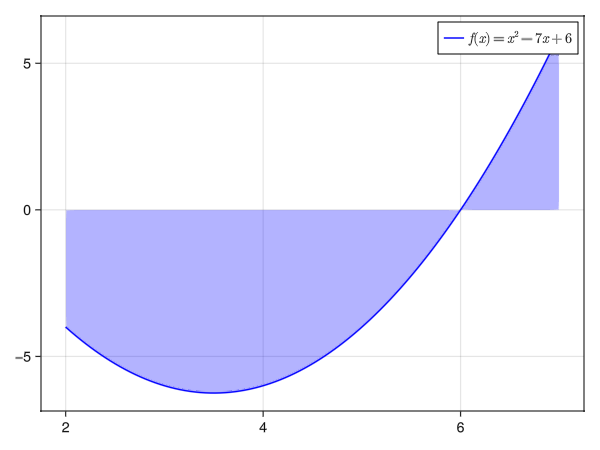

In [19]:
using SymPy, LaTeXStrings, GLMakie
@syms x::real
f(x) = x^2-7x+6
# Definimos un rango de valores para x.
xs = range(2, 7, length=100)
# Creamos la figura.
fig = Figure()
# Definimos los ejes.
ax = Axis(fig[1, 1])
# Dibujamos la región.
band!(ax, xs, f.(xs), [0], color = :blue, alpha = 0.3)
# Dibujamos la función.
lines!(ax, xs, f.(xs), color = :blue, label = L"$f(x)=x^2-7x+6$")
# Añadimos la leyenda.
axislegend(ax)
# Mostramos la figura.
fig

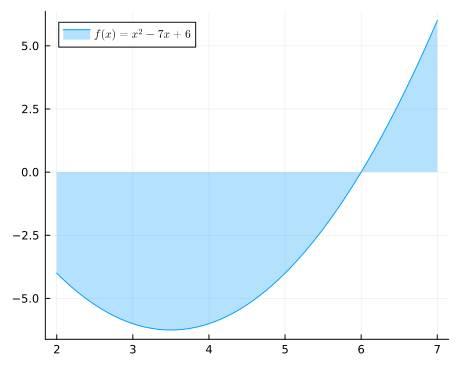

In [20]:
using Plots, SymPy, LaTeXStrings
@syms x::real
f(x) = x^2-7x+6
# Dibujamos la región y la gráfica de la función.
Plots.plot(f, 2, 7, fillrange = 0, fillalpha = 0.3, label = L"$f(x)=x^2-7x+6$")

In [21]:
# Calculamos primero las raíces de la función
solve(f(x))
# Descomponemos el intervalo de integración en los subintervalos [2,6] (función negativa) y [6,7] (función positiva) y calculamos las integrales por separado
-integrate(f(x), (x, 2, 6)) + integrate(f(x), (x, 6, 7))

43/2

In [22]:
integrate(abs(f(x)), (x, 2, 7))

43/2

In [23]:
using Plots, SymPy, LaTeXStrings
@syms x::real
f(x) = -x^2+6x
g(x) = x^2-2x
# Calculamos primero los puntos de corte de la función.
a, b = N.(solve(f(x)-g(x)))
# Calculamos el área comprendida entre las dos funciones entre los puntos de corte.
sol = integrate(f(x)-g(x), (x, a, b))

64/3

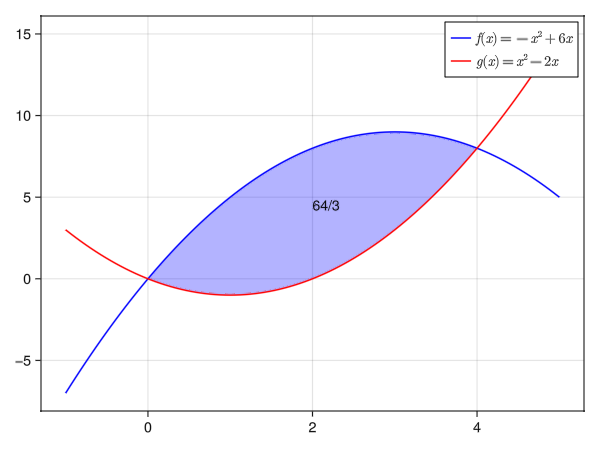

In [24]:
using GLMakie
# Definimos un rango de valores para x.
xs = range(-1, 5, length=100)
# Definimos un rango de valores para x en el intervalo de intersección.
xs2 = range(a, b, length=100)
# Creamos la figura.
fig = Figure()
# Definimos los ejes.
ax = Axis(fig[1, 1])
# Dibujamos la región.
band!(ax, xs2, f.(xs2), g.(xs2), color = :blue, alpha = 0.3)
# Dibujamos la función.
lines!(ax, xs, f.(xs), color = :blue, label = L"$f(x)=-x^2+6x$")
lines!(ax, xs, g.(xs), color = :red, label = L"$g(x)=x^2-2x$")
# Añadimos el area calculada.
text!(2, 4, text = "$sol")
# Añadimos la leyenda.
axislegend(ax)
# Mostramos la figura.
fig

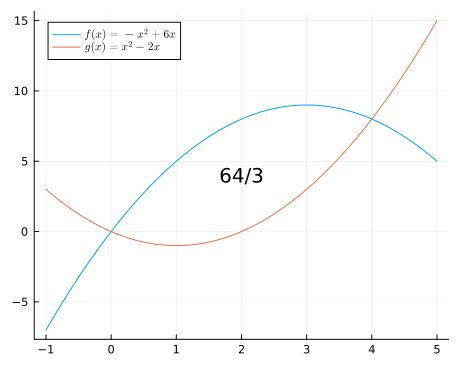

In [25]:
using Plots
Plots.plot!(g, a, b, fillrange = f, fillalpha = 0.3, label = "")
Plots.plot(f, -1, 5, label = L"$f(x)=-x^2+6x$")
Plots.plot!(g, label = L"$g(x)=x^2-2x$")
annotate!(2, 4, sol)

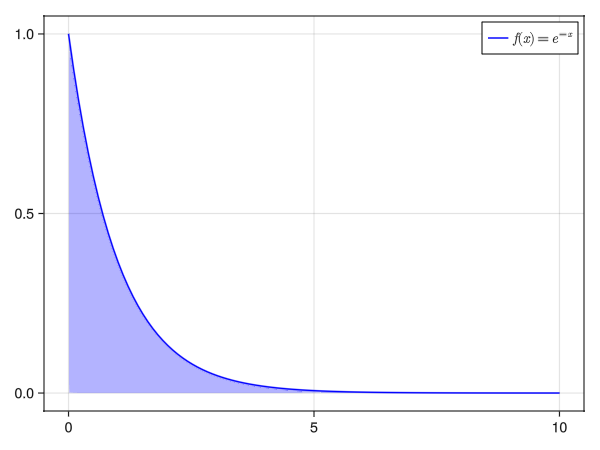

In [26]:
using SymPy, LaTeXStrings, GLMakie
@syms x::real
f(x) = exp(-x)
# Definimos un rango de valores para x.
xs = range(0, 10, length=100)
# Creamos la figura.
fig = Figure()
# Definimos los ejes.
ax = Axis(fig[1, 1])
# Dibujamos la región.
band!(ax, xs, f.(xs), 0, color = :blue, alpha = 0.3)
# Dibujamos la función.
lines!(ax, xs, f.(xs), color = :blue, label = L"$f(x)=e^{-x}$")
# Añadimos la leyenda.
axislegend(ax)
# Mostramos la figura.
fig

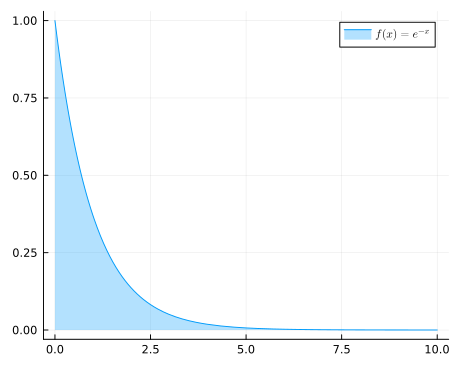

In [27]:
using SymPy, LaTeXStrings, Plots
@syms x::real
f(x) = exp(-x)
Plots.plot(f(x), 0, 10, fillrange = 0, fillalpha = 0.3, label = L"$f(x)=e^{-x}$")

In [28]:
integrate(f(x), (x, 0, oo))

1

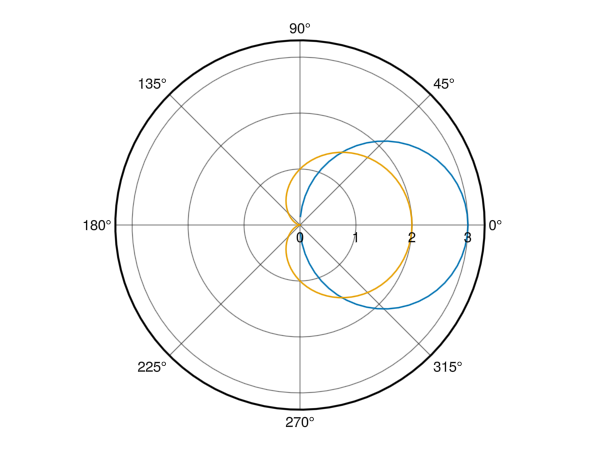

In [29]:
using SymPy, GLMakie
@syms θ::real
f(θ) = 1 + cos(θ)
g(θ) = 3cos(θ)
# Generamos los valores de θ
θs = range(0, 2pi, 100)
fig = Figure()
ax = PolarAxis(fig[1, 1], radius_at_origin = 0)
lines!(ax, θs, g.(θs), label =  L"g(\theta) = 3\cos(\theta)")
lines!(ax, θs, f.(θs), label = L"f(\theta) = 1 + \cos(\theta)")
fig

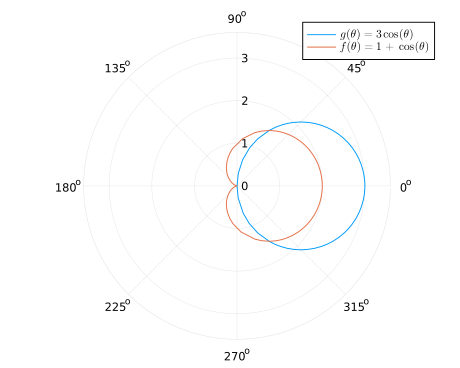

In [30]:
using SymPy, Plots
@syms θ::real
f(θ) = 1 + cos(θ)
g(θ) = 3*cos(θ)
Plots.plot(g, 0, pi, proj = :polar, label = L"g(\theta) = 3\cos(\theta)")
Plots.plot!(f, 0, 2pi, proj = :polar, label = L"f(\theta) = 1 + \cos(\theta)")

In [31]:
# Calculamos los puntos de corte de las funciones.
a, b = solve(f(θ)-g(θ))
# Ajustamos los ángulos para recorrer la región en el sentido correcto.
a, b = b - 2pi, a  
# Calculamos el de la región con forma de media luna encerrada entre g y f.
area_luna = integrate(g(θ)^2/2, (θ, a, b)) - integrate(f(θ)^2/2, (θ, a, b))
# Finalmente calculamos el area de g y le restamos el área de la media luna.
N(integrate(g(θ)^2/2, (θ, 0, pi)) - area_luna)

3.9269908169872414

In [32]:
using SymPy
@syms x::real
f(x) = sin(x)^2
1/(2*PI) * integrate(f(x), (x, 0, 2PI))

1/2

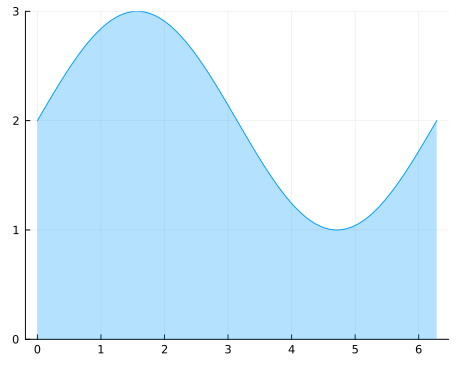

In [33]:
using SymPy, Plots
@syms x::real
f(x) = sin(x)+2
Plots.plot(f, 0, 2pi, ylim=(0,3), fillrange = 0, fillalpha = 0.3, label = "")

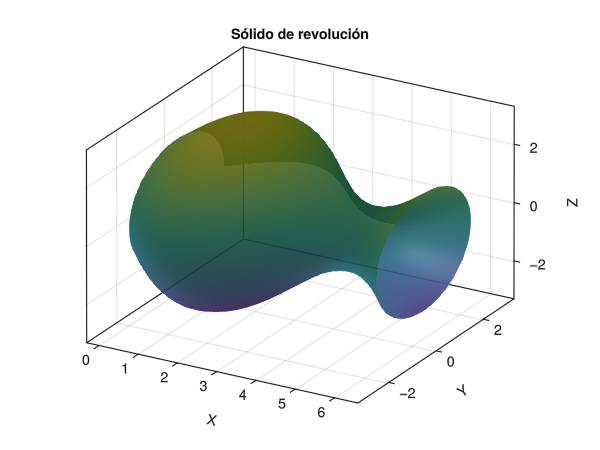

In [34]:
using GLMakie
# Generamos los valores de x y θ
u = range(0, 2pi, 100)
θ = range(0, 2pi, 100)
# Generamos los valores de X, Y y Z de la superficie de revolución.
xs = [i for i in u, j in θ]
ys = [f(i) * cos(j) for i in u, j in θ]
zs = [f(i) * sin(j) for i in u, j in θ]
# Creamos la figura.
fig = Figure()
# Definimos los ejes.
ax = Axis3(fig[1, 1], azimuth = -pi/3, title = "Sólido de revolución", xlabel = "X", ylabel = "Y", zlabel = "Z")
# Dibujamos la superficie de revolución
Makie.surface!(ax, xs, ys, zs, alpha = 0.9)
# Mostamos la figura.
fig

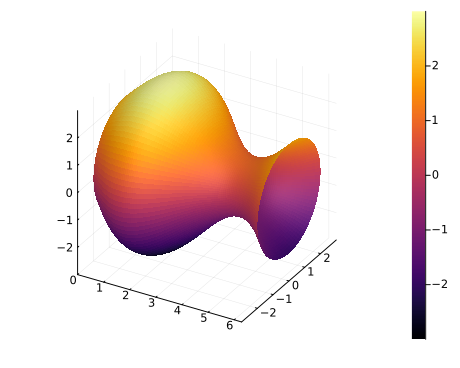

In [35]:
# Generamos los valores de x y θ
u = range(0, 2pi, 100)
θ = range(0, 2pi, 100)
# Generamos los valores de X, Y y Z de la superficie de revolución.
xs = [i for i in u, j in θ]
ys = [f(i) * cos(j) for i in u, j in θ]
zs = [f(i) * sin(j) for i in u, j in θ]
# Dibujamos la superficie de revolución
Plots.surface(xs, ys, zs)

In [36]:
N(integrate(pi*f(x)^2, (x, 0, 2pi)))

88.82643960980423

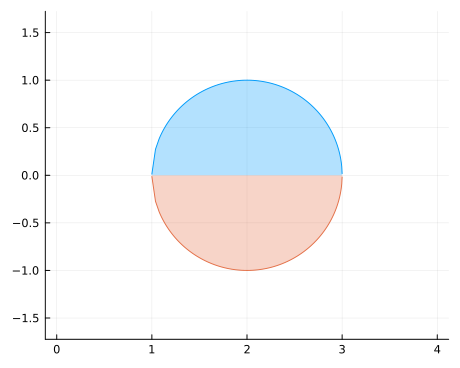

In [37]:
using SymPy, Plots
@syms x::real
f(x) = sqrt(1-(x-2)^2)
Plots.plot(f(x), 0, 4, fillrange = 0, fillalpha = 0.3, aspect_ratio = 1, label = "")
Plots.plot!(-f(x), 0, 4, fillrange = 0, fillalpha = 0.3, aspect_ratio = 1, label = "")

In [38]:
2 * integrate(2PI*x*f(x), (x, 1, 3))

   2
4⋅π 

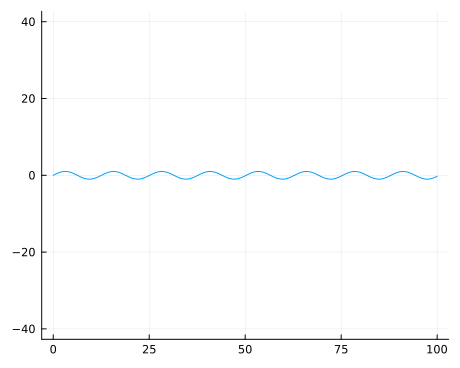

In [39]:
using SymPy, Plots
@syms x::real
f(x) = sin(x/2)
Plots.plot(f(x), 0, 100, aspect_ratio = 1, label = "")

In [40]:
using QuadGK
quadgk(sqrt(1+diff(f(x))^2), 0, 100)

(105.954416730336, 1.2200227161862642e-6)

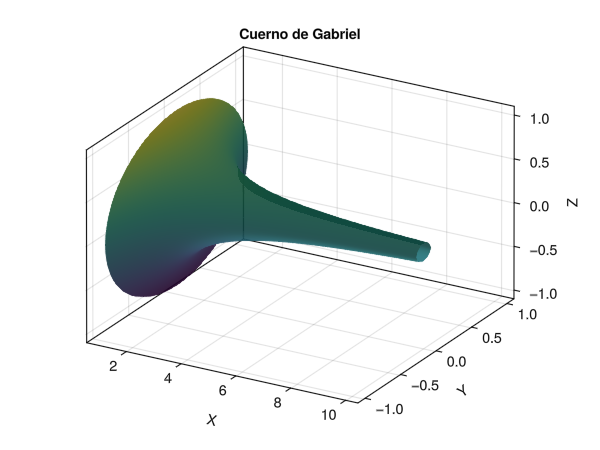

In [41]:
#| echo: false
using GLMakie
f(x) = 1/x
x = range(1, 10, 100)
θ = range(0, 2pi, 100)
# Generamos los valores de x, y y z de la superficie de revolución.
xs = [i for i in x, j in θ]
ys = [f(i) * cos(j) for i in x, j in θ]
zs = [f(i) * sin(j) for i in x, j in θ]
# Creamos la figura.
fig = Figure()
# Definimos los ejes.
ax = Axis3(fig[1, 1], azimuth = -pi/3, title = "Cuerno de Gabriel", xlabel = "X", ylabel = "Y", zlabel = "Z")
# Dibujamos la superficie de revolución
Makie.surface!(ax, xs, ys, zs, alpha = 0.9)
# Mostramos la figura.
fig

In [42]:
using SymPy
@syms x::real
f(x) = 1/x
integrate(PI*f(x)^2, (x, 1, oo))

π

In [43]:
using SymPy
@syms x::real
f(x) = 1/x
integrate(2PI*f(x)*sqrt(1+diff(f(x))^2), (x, 1, oo))

∞

In [44]:
using SymPy
@syms x::real y::real
f(x) = x^2/2
f⁻¹(y) = solve(y-f(x), x)[2]
# Volumen hasta una altura h
V(x) = integrate(PI*f⁻¹(y)^2, (y, 0, x))
# Nivel para un volumen de 100 m³
nivel = solve(V(x)-100)[2]

10
──
√π

In [45]:
δ = 900
gravedad = 9.81
N(integrate(gravedad*δ*PI*f⁻¹(y)^2*(8-y), (y, 0, nivel)))

3.7423801112379064e6

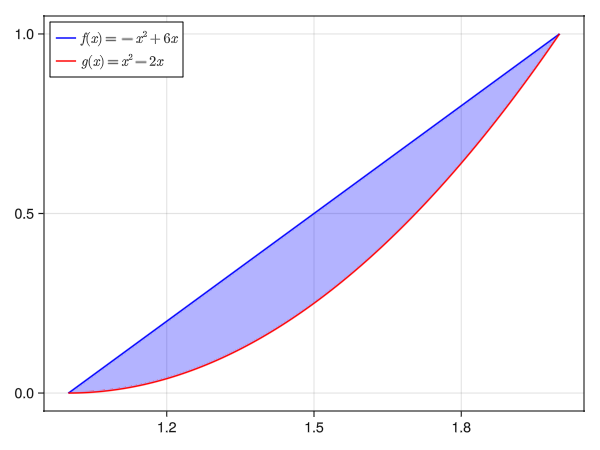

In [46]:
using SymPy, GLMakie
@syms x::real
f(x) = x-1
g(x) = (x-1)^2
# Calculo de los puntos de corte.
a, b = float(solve(f(x)-g(x)))
# Definimos un rango de valores para x.
xs = range(a, b, length=100)
# Creamos la figura.
fig = Figure()
# Definimos los ejes.
ax = Axis(fig[1, 1])
# Dibujamos la región.
band!(ax, xs, f.(xs), g.(xs), color = :blue, alpha = 0.3)
# Dibujamos la función.
lines!(ax, xs, f.(xs), color = :blue, label = L"$f(x)=-x^2+6x$")
lines!(ax, xs, g.(xs), color = :red, label = L"$g(x)=x^2-2x$")
# Añadimos la leyenda.
axislegend(ax, position = :lt)
# Mostramos la figura.
fig

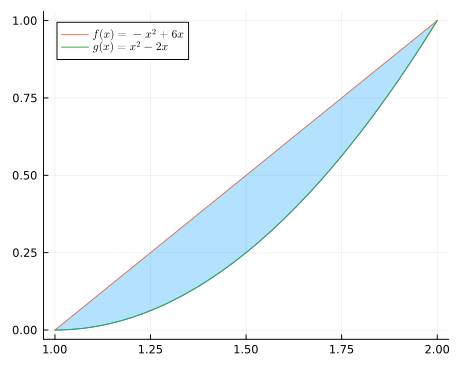

In [47]:
using SymPy, Plots
@syms x::real
f(x) = x-1
g(x) = (x-1)^2
# Calculo de los puntos de corte.
a, b = float(solve(f(x)-g(x)))
# Dibujamos la región. 
Plots.plot(g, a, b, fillrange = f, fillalpha = 0.3, label = "")
# Dibujamos la gráfica de f.
Plots.plot!(f, a, b, label = L"$f(x)=-x^2+6x$")
# Dibujamos la gráfica de g.
Plots.plot!(g, label = L"$g(x)=x^2-2x$")

In [48]:
# Coordenada x del centroide.
cx = N(integrate(x*(f(x)-g(x)), (x, a, b)) / integrate(f(x)-g(x), (x, a, b)))
# Coordenada y del centroide
cy = 1/2 * N(integrate(f(x)^2-g(x)^2, (x, a, b)) / integrate(f(x)-g(x), (x, a, b)))

0.39999999999999564

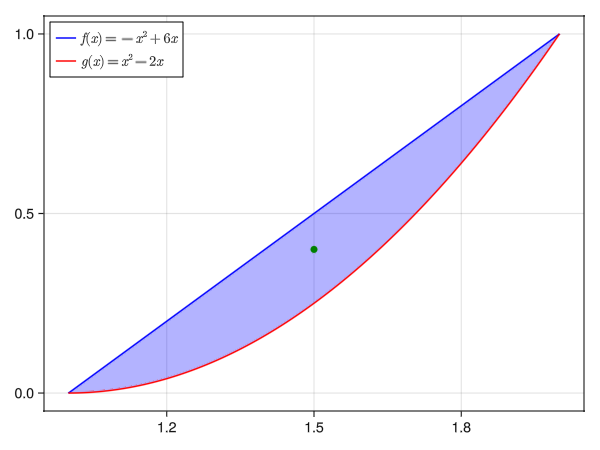

In [49]:
Makie.scatter!(Point2(cx, cy), color = :green, markersize = 10, label = "Centroide")
fig

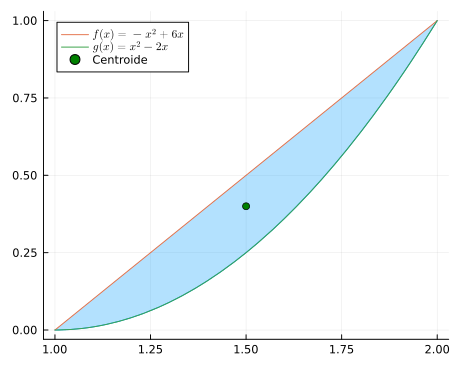

In [50]:
Plots.scatter!([cx], [cy], color = :green, label = "Centroide")

In [51]:
2*PI*cy*integrate(f(x)-g(x), (x,a, b))

0.133333333333332⋅π

In [52]:
2*PI*cx*integrate(f(x)-g(x), (x, a, b))

0.5⋅π

In [53]:
#| echo: false
using QuizQuestions, SymPy
nothing

In [54]:
#| echo: false
f(x) = sqrt(log(x))
Δx = 1/100
areas_sup = [f(1+i*Δx)*Δx for i = 1:100]
sol = sum(areas_sup)
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(0.5965478754886948, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [55]:
#| echo: false
@syms x::real
f(x) = sin(x)
g(x) = cos(x)
sol = N(integrate(abs(f(x)-g(x)), (x, 0, 2pi)))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(5.65685424949238, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [56]:
#| echo: false
using QuadGK
@syms x::real
f(x) = exp(-1/2 * x^2)/sqrt(2*pi)
sol = N(integrate(f(x), (x, -oo, oo)))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(1.0, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [57]:
#| echo: false
@syms θ::real
f(θ) = 2sin(3θ)
g(θ) = Sym(1)
a, b = solve(f(θ)-g(θ))
sol = N(3 * (integrate(f(θ)^2/2, (θ, a, b)) - integrate(g(θ)^2/2, (θ, a, b))))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(1.9132229549810364, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [58]:
#| echo: false
@syms t::real
T(t) = 100t*exp(-t)
sol = N(1/5 * integrate(T(t), (t, 0, 5)))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(19.191446360109744, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [59]:
#| echo: false
@syms x::real
f(x) = log(x)
g(x) = (x-1)/2
a, b = solve(f(x)-g(x))
sol = N(integrate(PI*(f(x)^2-g(x)^2), (x, a, b)))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(1.3244111068708535, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [60]:
#| echo: false
sol = N(integrate(2PI*x*(f(x)-g(x)), (x, a, b)))
numericq(sol, 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(4.3609631025976014, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [61]:
#| echo: false
@syms x::real
c(x) = 2cosh(x/2)
sol = quadgk(sqrt(1+diff(c(x))^2), -1, 1)
numericq(sol[1], 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(2.08438122197499, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [62]:
#| echo: false
using SymPy, QuadGK
@syms x::real
f(x) = sqrt(1-x^2/4)
sol = quadgk(2PI*f(x)*sqrt(1+diff(f(x))^2), -2, 2)
numericq(N(sol[1]), 1e-5, hint="Introducir hasta 5 decimales")

QuizQuestions.Numericq(21.478435327883727, 1.0e-5, "", "", "Introducir hasta 5 decimales", "", nothing)

In [63]:
#| echo: false
choices = ("La media es mayor que la mediana.", "La media es igual que la mediana", "La media es menor que la mediana")
answer = 1
radioq(choices, answer)

QuizQuestions.Radioq(("La media es mayor que la mediana.", "La media es igual que la mediana", "La media es menor que la mediana"), 1, [1, 2, 3], ("La media es mayor que la mediana.", "La media es igual que la mediana", "La media es menor que la mediana"), "", "", "", false)